# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

##  K-Means Clustering

###  Applying K-Means Clustering on BOW

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

## Data Cleaning :Deduplication

In [3]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries 
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

## Observation:-
It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

In [10]:
final.head()

Id   ProductId          UserId        ProfileName  \
22620  24750  2734888454  A13ISQV0U9GZIC          Sandikaye   
22621  24751  2734888454  A1C298ITT645B6  Hugh G. Pritchard   
2546    2774  B00002NCJC  A196AJHU9EASJN       Alex Chaffee   
2547    2775  B00002NCJC  A13RRPGE79XFFH           reader48   
1145    1244  B00002Z754  A3B8RCEI0FXFI6          B G Chase   

       HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
22620                     1                       1      0  1192060800   
22621                     0                       0      1  1195948800   
2546                      0                       0      1  1282953600   
2547                      0                       0      1  1281052800   
1145                     10                      10      1   962236800   

                              Summary  \
22620                   made in china   
22621               Dog Lover Delites   
2546                    thirty bucks?   
2547                     Flies Begone   
1145   WOW Make your own 'slickers' !   

                                                    Text  
22620  My dogs loves this chicken but its a product f...  
22621  Our dogs just love them.  I saw them in a pet ...  
2546   Why is this $[...] when the same product is av...  
2547   We have used the Victor fly bait for 3 seasons...  
1145   I just received my shipment and could hardly w...

## Prerpocessing Review Text
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags Remove any punctuations or limited set of special characters like , or . or # etc. Check if the word is made up of english letters and is not alpha-numeric Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters) Convert the word to lowercase Remove Stopwords Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming) After which we collect the words used to describe positive and negative reviews

In [11]:
# Importing necessary libraries

from bs4 import BeautifulSoup
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [13]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)# To remove urls
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()# To remove numbers
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) # To remove special characters
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)# To convert to lower case letters
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 46071/46071 [00:20<00:00, 2227.55it/s]


In [14]:
# Adding a new column "Review_Text" to the "final" dataframe with the Text "preprocessed_reviews"

final["Review_Text"]=preprocessed_reviews

In [15]:
final.head(2)

Id   ProductId          UserId        ProfileName  \
22620  24750  2734888454  A13ISQV0U9GZIC          Sandikaye   
22621  24751  2734888454  A1C298ITT645B6  Hugh G. Pritchard   

       HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
22620                     1                       1      0  1192060800   
22621                     0                       0      1  1195948800   

                 Summary                                               Text  \
22620      made in china  My dogs loves this chicken but its a product f...   
22621  Dog Lover Delites  Our dogs just love them.  I saw them in a pet ...   

                                             Review_Text  
22620  dogs loves chicken product china wont buying a...  
22621  dogs love saw pet store tag attached regarding...

## Sorting the data in descending order beased on Time Column

In [16]:
final=final.sort_values(by='Time',axis=0,ascending=False)

In [17]:
final.head(50)

Id   ProductId          UserId                        ProfileName  \
5259    5703  B009WSNWC4   AMP7K1O84DH1T                               ESTY   
8731    9564  B001EQ5IPQ   AA2104NO2VE8H                Lakshminarayan Iyer   
7451    8135  B0019GVYR2   ACSO5EDO1UMZ5                       SeekingBodhi   
39050  42397  B0014DXT5A   AZUCLRMHEBUG0                 T. HANLEY "reader"   
24496  26772  B004ZY4TK4   A4IL0CLL27Q33                         D. Brennan   
42269  45991  B007VQQT1K  A34P4V70RNC2YV                            S. Guss   
43268  47077  B001C4PKIK  A3IMXYITIO8WHN                  Thomas R. Jackson   
14526  15842  B007TJGZ5E  A3UOYYQS5Z47MS             David A. Levin "DaveL"   
15069  16426  B007TJGZ54  A29BJSTYH9W3JI                              Harry   
25112  27424  B003WEFSAI  A37O0JPLJ8BOXP                       Texaschick59   
7620    8322  B003VXFK44  A3GFZIL1E0Z5V8                           bloomen1   
32585  35471  B000WSHV1Q  A1YT628H711FN7                       Laura Tomevi   
38043  41317  B008NDSNAU  A2Z0XFW79HXASE          Kelby Scandrett "Kaiahso"   
16026  17512  B0045Z6K50  A3HM6TNYB7FNDL                          C. Furman   
19181  20930  B001L1MKLY  A38XYFHXEUNUW6                          bleaufire   
13539  14784  B000S859NC  A2H7STZ2URUCOE  Christopher Whedon "the odd bead"   
7156    7821  B000HB9TLI  A353IAF5Y1XE53               J. RIGOR "shop mama"   
30998  33768  B002ESVRWQ  A293T21WVQ3TDC  James E. Palmiter "Bargin Hunter"   
9513   10404  B005HI55CS  A36ERNIM0TKG3T                   Donald E. Bolton   
45413  49413  B000IHNCQO  A2DFSA2JXQKVY3                             C-Rush   
6548    7178  B004OQLIHK   AKHQMSUORSA91                           Pen Name   
37074  40274  B005VOOT52  A2FKFQQPU498JT                                 cc   
43703  47562  B004M0Y8T8  A2QJS6MHTIFSRI                            Georgie   
1005    1089  B004FD13RW    A1BPLP0BKERV                               Paul   
41621  45226  B00443Z35G  A3G23SMM1E1KPV                        L. E. Scott   
30235  32932  B001P05K8Q  A3L0B5NBTQ7ZHO                              Julie   
14299  15604  B000255OIG  A3SSEJ8IEM4YGW                            Seagaul   
5472    5924  B00523NRVO  A2JDXKFZ0PFHKU                   James W. Shondel   
14300  15605  B000255OIG   AUINI96NMGXUI                            Kkrys23   
22401  24518  B0016JJEFG   AO9WE22147CRH                       Arvind Rajan   
9         10  B00171APVA  A21BT40VZCCYT4                      Carol A. Reed   
29158  31794  B0049D7HRS  A3LR9HCV3D96I3                       Gypsy Healer   
30236  32933  B001P05K8Q  A1839EJ21BLV9K                   R. D. Mendelsohn   
25039  27342  B0078XKX0E  A3HVA6BTVB1UYP     Christina A. Salemi "Stinarat"   
24417  26689  B000YSS7EO   AQH6FCS9F0Z9R                        Marz "Marz"   
28136  30686  B000EYRBSQ  A3IKXWH8CHWUTX                    Old Man Running   
47609  51758  B0028H06ZW  A1H31XV4OODPAK                          Cassandra   
45779  49811  B000EUIZ8K   AOHXBDUSQ62SL                               matt   
43992  47882  B004SRH2B6  A2CUGPQKBWYTQH                              Marie   
41728  45338  B001KP8EO8   ABWCUS3HBDZRS                           Rachel R   
25068  27374  B0040BESXK   A7UQE24D5SB3R                                AMF   
25067  27373  B0040BESXK   AX61H3L62SDDJ                      Carly Lockard   
38603  41915  B006Q7YFLQ   A7EU2BWLLCJY2        Claire Jordan "Filmmaker -"   
49041  53271  B00370ESNU   AD94E61T77UFV                        Scott Clark   
24948  27243  B0033HGLTG  A3BHG5R6IUICRU         T. Moscovitch "jazz hound"   
11893  12954  B000ET93N2  A3BIAXCA7ILMUH                  Rosemarie Dowdell   
9193   10063  B003EML8PM  A3VERUHFCZ5S51                              kathy   
24804  27091  B000EM8U1U  A3W4Y2B3F35KF8                    PeacefulJourney   
16812  18348  B004BKVQF8   AG4YGLLIE8BWP                           Miwintee   
17719  19321  B002ACU9XY  A32C7CN1ZWSDEK               Suzan

In [18]:
# Dropping unnecessary columns and keeping only Review_Text and Score Columns

final_df=final[['Review_Text']]

In [19]:
final_df.head()

Review_Text
5259   purchased product local store ny kids love qui...
8731   hi disappointed past shipment received one coc...
7451   called bob red mill customer service g search ...
39050  used years gives long lasting energy boost no ...
24496  nespresso makes great coffee great machines sw...

In [20]:
final_df.shape

(46071, 1)

In [21]:
# Assigning the data to X

X=final_df['Review_Text'].values

In [22]:
# Converting to BOW

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=500)
vectorizer.fit(X) # fitting the data
X_bow = vectorizer.transform(X)# Transforming the data
print("After vectorizations")
print(X_bow.shape)

After vectorizations
(46071, 578)


## Finding the best k(number of clusters) value in k means using elbow method

In [23]:
from sklearn.cluster import KMeans

In [24]:
k=list(range(2,11))
wcss=[]# wcss=within cluster sum of squred error
for i in k:
    km=KMeans(n_clusters=i,n_jobs=-1)
    km.fit(X_bow)
    wcss.append(km.inertia_)
    

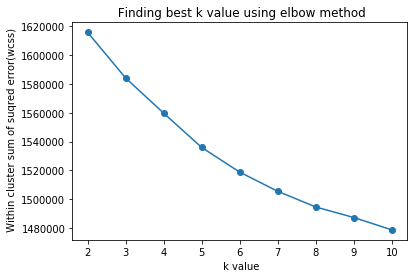

In [29]:
# wcss vs k plot

plt.xlabel(" k value")
plt.ylabel(" Within cluster sum of suqred error(wcss)")
plt.title(" Finding best k value using elbow method")
plt.plot(k,wcss,marker='o')

From the above plot,we can see that the best k value is 6.

## Building k-means using best k value

In [30]:
# Standardizing the data since k-means is distance based algorithm

from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_bow_std=sc.fit_transform(X_bow)

In [31]:
from sklearn.cluster import KMeans
km_bow=KMeans(n_clusters=6,random_state=3,n_jobs=-1,init='k-means++')
km_bow.fit(X_bow_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=3, tol=0.0001, verbose=0)

In [32]:
# Finding the clusters labels
clusters_bow=km_bow.labels_

In [33]:
len(clusters_bow)

46071

In [34]:
# Finding the unique clusters
np.unique(clusters_bow)

array([0, 1, 2, 3, 4, 5])

In [35]:
# Finding the Centroids

Centroids_bow=km_bow.cluster_centers_

In [36]:
Centroids_bow

array([[0.67275223, 0.40586337, 1.12992598, ..., 0.9547569 , 0.93135843,
        0.26789614],
       [0.10940762, 0.13283099, 0.09517153, ..., 0.04168758, 0.08739024,
        0.11954255],
       [0.26382102, 0.23752204, 0.37786441, ..., 0.23818472, 0.24494407,
        0.18491994],
       [0.37009918, 0.31089529, 0.50965643, ..., 0.2961866 , 0.24634903,
        0.04801754],
       [0.16856583, 0.19486645, 0.65964097, ..., 0.28835198, 0.3092493 ,
        0.08790109],
       [0.25916531, 0.21906368, 0.28953066, ..., 0.22987649, 0.38666436,
        0.07644594]])

### Wordclouds of clusters obtained after applying k-means on BOW

In [37]:
cluster1=[]
cluster2=[]
cluster3=[]
cluster4=[]
cluster5=[]
cluster6=[]

for i in range(len(clusters_bow)):
    if clusters_bow[i]==0:
        cluster1.append(X[i])
    elif clusters_bow[i]==1:
        cluster2.append(X[i])
    elif clusters_bow[i]==2:
        cluster3.append(X[i])
    elif clusters_bow[i]==3:
        cluster4.append(X[i])
    elif clusters_bow[i]==4:
        cluster5.append(X[i])
   
    else:
        cluster6.append(X[i])
        

In [38]:
print("Cluster1 length:",len(cluster1))
print("Cluster2 length:",len(cluster2))
print("Cluster3 length:",len(cluster3))
print("Cluster4 length:",len(cluster4))
print("Cluster5 length:",len(cluster5))
print("Cluster6 length:",len(cluster6))

Cluster1 length: 749
Cluster2 length: 32699
Cluster3 length: 8320
Cluster4 length: 2012
Cluster5 length: 930
Cluster6 length: 1361


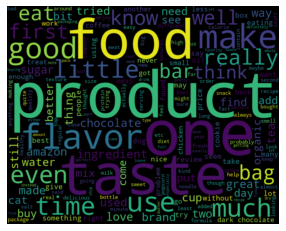

In [39]:
# Generating the word cloud for cluster1

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster1))

# Displaying the word cloud for cluster1

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

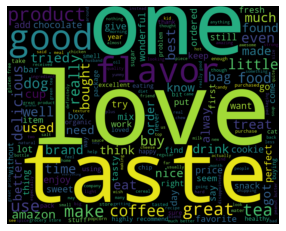

In [40]:
# Generating the word cloud for cluster2

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster2))

# Displaying the word cloud for cluster2

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

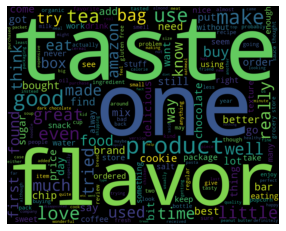

In [41]:
# Generating the word cloud for cluster3

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster3))

# Displaying the word cloud for cluster3

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

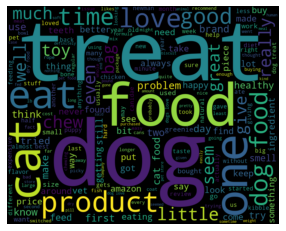

In [42]:
# Generating the word cloud for cluster4

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster4))

# Displaying the word cloud for cluster4

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

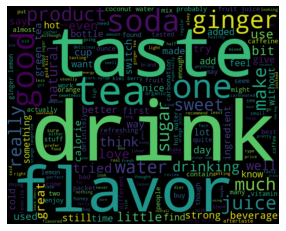

In [43]:
# Generating the word cloud for cluster5

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster5))

# Displaying the word cloud for cluster5

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

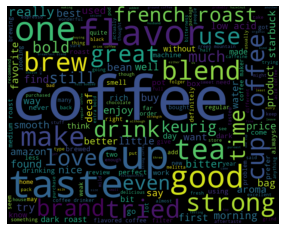

In [44]:
# Generating the word cloud for cluster6

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster6))

# Displaying the word cloud for cluster6

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

###  Applying K-Means Clustering on TFIDF

In [57]:
tf_idf_vect = TfidfVectorizer(min_df=10,max_features=500)
tf_idf_vect.fit(X) # fitting the data

# we use the fitted Tfidf vectorizer to convert the text to vector
X_tfidf = tf_idf_vect.transform(X)

print("After vectorizations")
print(X_tfidf.shape)

After vectorizations
(46071, 500)


## Finding best k value using elbow method

In [58]:
k=list(range(2,11))
wcss=[]# wcss=within cluster sum of squred error
for i in k:
    km=KMeans(n_clusters=i,n_jobs=-1)
    km.fit(X_tfidf)
    wcss.append(km.inertia_)
    

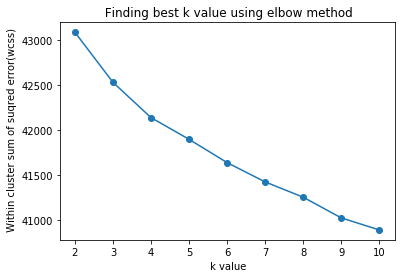

In [60]:
# wcss vs k plot

plt.xlabel(" k value")
plt.ylabel(" Within cluster sum of suqred error(wcss)")
plt.title(" Finding best k value using elbow method")
plt.plot(k,wcss,marker='o')

From the plot we can see that the best k value is 4.

## Building k-means using best k value

In [61]:
# Standardizing the data since k-means is distance based algorithm

from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_tfidf_std=sc.fit_transform(X_tfidf)

In [62]:
from sklearn.cluster import KMeans
km_tfidf=KMeans(n_clusters=4,random_state=4,n_jobs=-1,init='k-means++')
km_tfidf.fit(X_tfidf_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=4, tol=0.0001, verbose=0)

In [63]:
# Finding the clusters labels
clusters_tfidf=km_tfidf.labels_

In [64]:
np.unique(clusters_tfidf)

array([0, 1, 2, 3])

In [65]:
len(clusters_tfidf)

46071

In [66]:
# Finding the Centroids

Centroids_tfidf=km_tfidf.cluster_centers_

In [67]:
Centroids_tfidf

array([[0.15983777, 0.21770101, 0.02792087, ..., 0.11593623, 0.12679711,
        0.02972664],
       [0.1005635 , 0.12516837, 0.34278884, ..., 0.09190585, 0.20327792,
        0.06123057],
       [0.08338158, 0.14533117, 0.02645318, ..., 0.1393438 , 0.13080558,
        0.30774668],
       [0.19227645, 0.15512978, 0.02083152, ..., 0.09942894, 0.11699377,
        0.10463196]])

###  Wordclouds of clusters obtained after applying k-means on TFIDF

In [75]:
cluster1=[]
cluster2=[]
cluster3=[]
cluster4=[]

for i in range(len(clusters_tfidf)):
    if clusters_tfidf[i]==0:
        cluster1.append(X[i])
    elif clusters_tfidf[i]==1:
        cluster2.append(X[i])
    elif clusters_tfidf[i]==2:
        cluster3.append(X[i])
   
    else:
        cluster4.append(X[i])
        

In [76]:
print("Cluster1 length:",len(cluster1))
print("Cluster2 length:",len(cluster2))
print("Cluster3 length:",len(cluster3))
print("Cluster4 length:",len(cluster4))

Cluster1 length: 5757
Cluster2 length: 9192
Cluster3 length: 7476
Cluster4 length: 23646


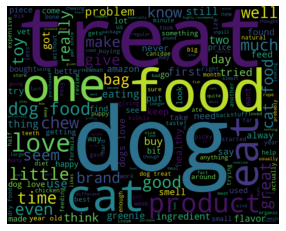

In [78]:
# Generating the word cloud for cluster1

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster1))

# Displaying the word cloud for cluster1

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

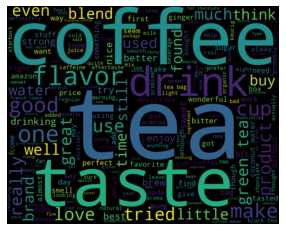

In [79]:
# Generating the word cloud for cluster2

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster2))

# Displaying the word cloud for cluster2

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

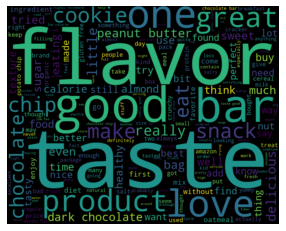

In [80]:
# Generating the word cloud for cluster3

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster3))

# Displaying the word cloud for cluster3

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

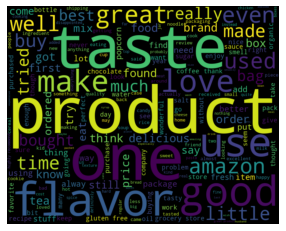

In [81]:
# Generating the word cloud for cluster4

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster4))

# Displaying the word cloud for cluster4

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

### Applying K-Means Clustering on AVG W2V

In [45]:
list_of_sentance_X=[]
for sentance in X:
    list_of_sentance_X.append(sentance.split())

In [46]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [47]:
# This line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_X,min_count=5,size=50, workers=4)

In [48]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12798
sample words  ['purchased', 'product', 'local', 'store', 'ny', 'kids', 'love', 'quick', 'easy', 'meal', 'put', 'toaster', 'oven', 'toast', 'min', 'ready', 'eat', 'strongly', 'recommend', 'hi', 'disappointed', 'past', 'shipment', 'received', 'one', 'coconut', 'water', 'boxes', 'leaking', 'spoiled', 'thanks', 'called', 'bob', 'red', 'mill', 'customer', 'service', 'g', 'search', 'company', 'number', 'contact', 'us', 'site', 'annoyed', 'learn', 'none', 'baking', 'soda', 'contains']


## Converting Reviews into Numerical Vectors using W2V vectors
## Algorithm: Avg W2V

In [49]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_X): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_X = np.array(sent_vectors)


100%|███████████████████████████████████████████████████████████████████████████| 46071/46071 [01:29<00:00, 512.84it/s]


In [50]:
print(sent_vectors_X.shape)
print(sent_vectors_X[0])

(46071, 50)
[-0.06428744 -0.06896721  0.29120084 -0.23588067  0.66954134 -0.65868458
 -0.30960024 -0.02105519  0.3497673   0.68098645  0.38719742 -0.09175966
 -1.06414968 -0.34642789 -0.0211233   0.69964343 -0.08260938  0.4345347
  0.59997517  0.07130321 -0.95158575  0.24273726  0.14996563 -0.13271038
 -0.35312673  0.26092715  0.86710876 -0.16924307 -0.12467002  0.17543567
 -0.00994337 -0.08960275 -0.33963631 -0.36971454 -0.02675383 -1.38761473
  0.86058454  0.38186207  0.1683655  -0.30174858 -0.10613293 -0.72612643
  0.16532852 -0.31266961 -0.26047406  1.07684137  0.11036347  0.71086111
 -0.30087533 -0.60708347]


## Finding best value using elbow method

In [51]:
k=list(range(2,11))
wcss=[]# wcss=within cluster sum of squred error
for i in k:
    km=KMeans(n_clusters=i,n_jobs=-1)
    km.fit(sent_vectors_X)
    wcss.append(km.inertia_)
    

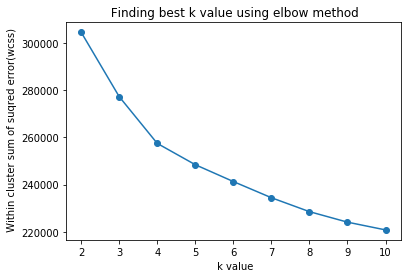

In [52]:
# wcss vs k plot

plt.xlabel(" k value")
plt.ylabel(" Within cluster sum of suqred error(wcss)")
plt.title(" Finding best k value using elbow method")
plt.plot(k,wcss,marker='o')

From the plot,we can see that the best k value is 4.

## Building k-means using best k value

In [54]:
# Standardizing the data since k-means is distance based algorithm

from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_avgw2v_std=sc.fit_transform(sent_vectors_X)

In [55]:
from sklearn.cluster import KMeans
km_avgw2v=KMeans(n_clusters=4,random_state=5,n_jobs=-1,init='k-means++')
km_avgw2v.fit(X_avgw2v_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=5, tol=0.0001, verbose=0)

In [57]:
# Finding the clusters labels
clusters_avgw2v=km_avgw2v.labels_

In [58]:
np.unique(clusters_avgw2v)

array([0, 1, 2, 3])

In [59]:
len(clusters_avgw2v)

46071

In [61]:
# Finding the Centroids

Centroids_avgw2v=km_avgw2v.cluster_centers_

In [62]:
Centroids_avgw2v

array([[-6.85210664e-01,  1.14643823e-01, -7.39361584e-01,
        -3.00656038e-01,  1.15561379e+00, -1.81627085e+00,
        -6.42149717e-01, -6.34201437e-01, -5.42244947e-01,
         1.40016588e+00,  1.38630085e+00,  2.94554047e-01,
        -7.87333890e-01, -6.90448460e-01, -9.24604258e-01,
         1.40475764e+00, -7.34974508e-01,  2.00418552e+00,
         1.26290411e-01,  1.65175438e-01, -3.47199442e-01,
        -1.06507840e+00,  1.19174812e+00, -6.29555299e-01,
        -1.18747579e+00,  5.43091037e-01,  4.44409973e-01,
        -9.76242725e-01, -6.51736454e-01,  3.77257138e-01,
        -2.05439371e-01, -9.74067666e-01,  2.03942798e-01,
        -7.49429299e-01, -1.14051260e+00, -1.28726216e+00,
         1.78636957e-01,  6.39950541e-01,  3.35392845e-02,
        -6.86807431e-01,  3.35795028e-01, -1.65154288e+00,
         1.78687435e-02,  1.06907433e-01,  1.44173405e-01,
         1.53549240e-01,  3.88337437e-02,  2.43990648e-01,
         3.36388600e-01, -1.25815950e+00],
       [ 4.72

In [63]:
len(Centroids_avgw2v)

4

###  Wordclouds of clusters obtained after applying k-means on AVG W2V

In [64]:
cluster1=[]
cluster2=[]
cluster3=[]
cluster4=[]

for i in range(len(clusters_avgw2v)):
    if clusters_avgw2v[i]==0:
        cluster1.append(X[i])
    elif clusters_avgw2v[i]==1:
        cluster2.append(X[i])
    elif clusters_avgw2v[i]==2:
        cluster3.append(X[i])
   
    else:
        cluster4.append(X[i])
        

In [65]:
print("Cluster1 length:",len(cluster1))
print("Cluster2 length:",len(cluster2))
print("Cluster3 length:",len(cluster3))
print("Cluster4 length:",len(cluster4))

Cluster1 length: 12831
Cluster2 length: 6663
Cluster3 length: 7818
Cluster4 length: 18759


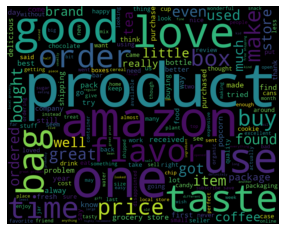

In [66]:
# Generating the word cloud for cluster1

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster1))

# Displaying the word cloud for cluster1

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

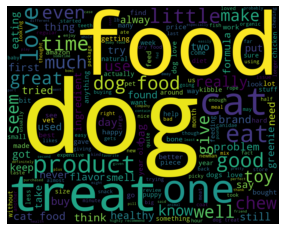

In [67]:
# Generating the word cloud for cluster2

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster2))

# Displaying the word cloud for cluster2

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

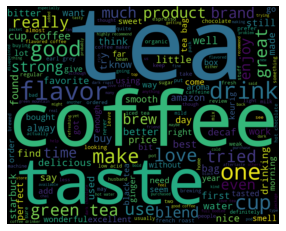

In [68]:
# Generating the word cloud for cluster3

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster3))

# Displaying the word cloud for cluster3

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

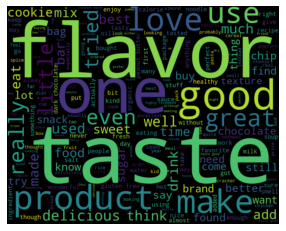

In [69]:
# Generating the word cloud for cluster4

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster4))

# Displaying the word cloud for cluster4

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

### Applying K-Means Clustering on TFIDF W2V

In [70]:
model = TfidfVectorizer(min_df=10,max_features=500)
tf_idf_matrix_X = model.fit_transform(X)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [71]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_X = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_X): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_X.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 46071/46071 [01:46<00:00, 431.37it/s]


In [72]:
tfidf_sent_vectors_X= np.array(tfidf_sent_vectors_X)

In [73]:
print(tfidf_sent_vectors_X.shape)
print(tfidf_sent_vectors_X[0])

(46071, 50)
[-1.06339971e-01 -5.73778272e-02 -1.97085926e-02 -4.29019741e-01
  8.28463995e-01 -9.87198822e-01 -4.12565887e-01 -3.26858012e-01
 -9.43660385e-03  8.57205308e-01  5.08457604e-01 -4.50698605e-01
 -1.28618198e+00 -2.66116125e-01 -1.90897769e-03  8.74892663e-01
  2.11092903e-01  6.51904614e-01  8.63845956e-01 -3.57083476e-02
 -9.40922411e-01  3.14798407e-01  4.62494921e-01 -7.68377430e-02
 -5.95935116e-01  5.01848577e-01  9.94698195e-01  5.05392159e-02
 -1.71423031e-01 -1.34694082e-01 -1.05341386e-01 -1.42069403e-02
 -1.59210256e-01 -7.02295701e-01 -7.50055339e-02 -2.23055529e+00
  1.08447330e+00  6.73949837e-01  8.56498260e-02 -4.93833153e-01
 -5.09150707e-01 -8.88449931e-01  3.08346821e-01 -3.11374755e-01
 -2.04369060e-01  1.56114676e+00  1.07232061e-01  5.89132400e-01
 -1.39439275e-01 -8.20467360e-01]


## Finding best k value using elbow method

In [74]:
k=list(range(2,11))
wcss=[]# wcss=within cluster sum of squred error
for i in k:
    km=KMeans(n_clusters=i,n_jobs=-1)
    km.fit(tfidf_sent_vectors_X)
    wcss.append(km.inertia_)
    

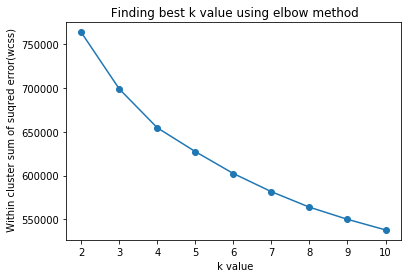

In [75]:
# wcss vs k plot

plt.xlabel(" k value")
plt.ylabel(" Within cluster sum of suqred error(wcss)")
plt.title(" Finding best k value using elbow method")
plt.plot(k,wcss,marker='o')

From the plot,we can see that the best k value is 4.

## Building k-means using best k value

In [76]:
# Standardizing the data since k-means is distance based algorithm

from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_tfidfavgw2v_std=sc.fit_transform(tfidf_sent_vectors_X)

In [78]:
from sklearn.cluster import KMeans
km_tfidfavgw2v=KMeans(n_clusters=4,random_state=6,n_jobs=-1,init='k-means++')
km_tfidfavgw2v.fit(X_tfidfavgw2v_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=6, tol=0.0001, verbose=0)

In [79]:
# Finding the clusters labels
clusters_tfidfavgw2v=km_tfidfavgw2v.labels_

In [80]:
np.unique(clusters_tfidfavgw2v)

array([0, 1, 2, 3])

In [81]:
len(clusters_tfidfavgw2v)

46071

In [82]:
# Finding Centroids

Centroids_tfidfavgw2v=km_tfidfavgw2v.cluster_centers_

In [83]:
Centroids_tfidfavgw2v

array([[-0.34668005, -0.72096827, -1.59267298, -0.26679944,  1.22821569,
        -2.58218125,  0.26693579,  0.64346308, -1.70077413,  0.66993629,
        -0.55834269,  1.60709663, -1.02827287, -0.22289767, -0.59315067,
        -0.6133707 , -0.15619114,  2.59167237,  0.59631835, -0.6825001 ,
        -0.58533617, -1.63978876,  1.45517116,  1.30070641, -0.05713862,
         0.53009387,  0.06038496, -1.53632256, -1.79016277,  0.87724953,
        -0.8599231 , -1.84128471, -1.53220256, -0.04607776, -2.03850523,
         0.17304101, -0.59707918, -0.96372536,  1.11519622, -0.46814542,
         0.72636052, -1.29817005,  0.48547789,  1.56383725, -0.70016614,
        -0.91720676,  0.24297742,  1.41785186,  1.68967652,  0.13050788],
       [ 0.26806826,  1.87787084, -0.9011676 ,  1.55723625,  2.19133265,
        -1.19571248,  1.2900877 , -0.64132588, -0.05400526, -0.36266468,
         0.23104012, -0.69039341, -0.34253455, -0.66676967,  0.66756039,
         1.79978337, -0.18455065,  1.4365542 ,  0.

In [84]:
len(Centroids_tfidfavgw2v)

4

###  Wordclouds of clusters obtained after applying k-means on TFIDF W2V

In [86]:
cluster1=[]
cluster2=[]
cluster3=[]
cluster4=[]

for i in range(len(clusters_tfidfavgw2v)):
    if clusters_tfidfavgw2v[i]==0:
        cluster1.append(X[i])
    elif clusters_tfidfavgw2v[i]==1:
        cluster2.append(X[i])
    elif clusters_tfidfavgw2v[i]==2:
        cluster3.append(X[i])
   
    else:
        cluster4.append(X[i])
        

In [87]:
print("Cluster1 length:",len(cluster1))
print("Cluster2 length:",len(cluster2))
print("Cluster3 length:",len(cluster3))
print("Cluster4 length:",len(cluster4))

Cluster1 length: 6148
Cluster2 length: 5620
Cluster3 length: 19166
Cluster4 length: 15137


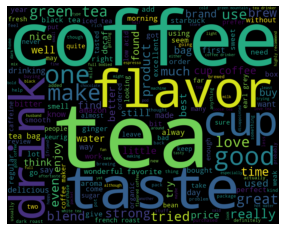

In [88]:
# Generating the word cloud for cluster1

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster1))

# Displaying the word cloud for cluster1

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

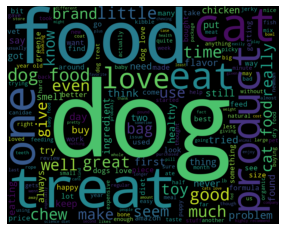

In [89]:
# Generating the word cloud for cluster2

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster2))

# Displaying the word cloud for cluster2

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

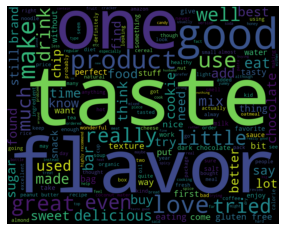

In [90]:
# Generating the word cloud for cluster3

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster3))

# Displaying the word cloud for cluster3

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

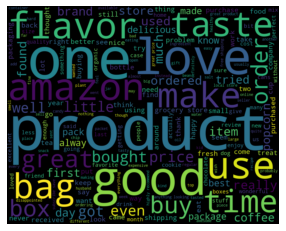

In [91]:
# Generating the word cloud for cluster4

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster4))

# Displaying the word cloud for cluster4

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

##  Agglomerative Clustering

###  Applying Agglomerative Clustering on AVG W2V

In [41]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (10000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

## Data Cleaning :Deduplication

In [42]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [43]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [44]:
#Deduplication of entries 
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [45]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.64

In [46]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

## Observation:-
It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [47]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [48]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(9564, 10)


1    7976
0    1588
Name: Score, dtype: int64

In [49]:
final.head()

Id   ProductId          UserId   ProfileName  HelpfulnessNumerator  \
2547  2775  B00002NCJC  A13RRPGE79XFFH      reader48                     0   
2546  2774  B00002NCJC  A196AJHU9EASJN  Alex Chaffee                     0   
1145  1244  B00002Z754  A3B8RCEI0FXFI6     B G Chase                    10   
1146  1245  B00002Z754  A29Z5PI9BW2PU3        Robbie                     7   
8695  9526  B00005V3DC    APASCXWTM041      Ed Raton                     0   

      HelpfulnessDenominator  Score        Time  \
2547                       0      1  1281052800   
2546                       0      1  1282953600   
1145                      10      1   962236800   
1146                       7      1   961718400   
8695                       0      1  1350604800   

                             Summary  \
2547                    Flies Begone   
2546                   thirty bucks?   
1145  WOW Make your own 'slickers' !   
1146                   Great Product   
8695         Good, effective product   

                                                   Text  
2547  We have used the Victor fly bait for 3 seasons...  
2546  Why is this $[...] when the same product is av...  
1145  I just received my shipment and could hardly w...  
1146  This was a really good idea and the final prod...  
8695  Good flavor, unique in all the teas that I've ...

## Prerpocessing Review Text
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags Remove any punctuations or limited set of special characters like , or . or # etc. Check if the word is made up of english letters and is not alpha-numeric Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters) Convert the word to lowercase Remove Stopwords Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming) After which we collect the words used to describe positive and negative reviews

In [50]:
# Importing necessary libraries

from bs4 import BeautifulSoup
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [51]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [52]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)# To remove urls
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()# To remove numbers
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) # To remove special characters
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)# To convert to lower case letters
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 9564/9564 [00:05<00:00, 1875.05it/s]


In [53]:
# Adding a new column "Review_Text" to the "final" dataframe with the Text "preprocessed_reviews"

final["Review_Text"]=preprocessed_reviews

In [54]:
final.head(2)

Id   ProductId          UserId   ProfileName  HelpfulnessNumerator  \
2547  2775  B00002NCJC  A13RRPGE79XFFH      reader48                     0   
2546  2774  B00002NCJC  A196AJHU9EASJN  Alex Chaffee                     0   

      HelpfulnessDenominator  Score        Time        Summary  \
2547                       0      1  1281052800   Flies Begone   
2546                       0      1  1282953600  thirty bucks?   

                                                   Text  \
2547  We have used the Victor fly bait for 3 seasons...   
2546  Why is this $[...] when the same product is av...   

                                            Review_Text  
2547  used victor fly bait seasons ca not beat great...  
2546  product available victor traps unreal course t...

## Sorting the data in descending order beased on Time Column

In [55]:
final=final.sort_values(by='Time',axis=0,ascending=False)

In [56]:
final.head(50)

Id   ProductId          UserId                           ProfileName  \
5259   5703  B009WSNWC4   AMP7K1O84DH1T                                  ESTY   
8731   9564  B001EQ5IPQ   AA2104NO2VE8H                   Lakshminarayan Iyer   
9513  10404  B005HI55CS  A36ERNIM0TKG3T                      Donald E. Bolton   
5472   5924  B00523NRVO  A2JDXKFZ0PFHKU                      James W. Shondel   
6548   7178  B004OQLIHK   AKHQMSUORSA91                              Pen Name   
7156   7821  B000HB9TLI  A353IAF5Y1XE53                  J. RIGOR "shop mama"   
1005   1089  B004FD13RW    A1BPLP0BKERV                                  Paul   
7451   8135  B0019GVYR2   ACSO5EDO1UMZ5                          SeekingBodhi   
7620   8322  B003VXFK44  A3GFZIL1E0Z5V8                              bloomen1   
9        10  B00171APVA  A21BT40VZCCYT4                         Carol A. Reed   
993    1076  B001GE3T1G  A3Q63ZZGUICVFW                   Charlene Sonnenborn   
5436   5888  B003KLSZGW  A20F3R666C5I21            D. Leong "customer review"   
7621   8323  B003VXFK44  A21VWSCGW7UUAR                            Ian Wilmot   
5661   6129  B003U9TAH2  A1QA6BI0T8A81I                              M.A.M.B.   
6802   7444  B005HVDZRM  A1QU5WEF3LS9YD                                  Frog   
5303   5749  B003TIVBSU  A26OE4A844VN8C                                    YF   
4540   4931  B000FYYOZI  A13Q9TG853K1J6             P. ONeill "RighteousDude"   
9193  10063  B003EML8PM  A3VERUHFCZ5S51                                 kathy   
6726   7365  B000EDG4TE  A3SFGVQV4SJHJH                         Rebecca Marsh   
802     868  B000VKYKTG  A3LRR63WLQ3N3O                                YOToyo   
707     761  B006JWQFC0  A2C9XE9I8RSKNX                            J. Johnson   
2770   3015  B0025UALB6   AWA0H9KO7CFPD                        Susan C. Parks   
8758   9593  B002PO09MS  A3AUV66BA16V2R                           Queen Baker   
9723  10629  B004GU3YXU  A1GXSI71DMXICZ                             chuckbeck   
4726   5128  B0028VAQSU   AFHSVU5Z9DON2                              Yogeezer   
9625  10526  B001BM6Q0Y  A3816H8FA436OJ                             Sue "Sue"   
4596   4991  B004TTSB2C  A3DMQM4OQONEMK                                 Jazzy   
7144   7809  B00474H936  A1GGZ5O55K7E7P           sjsmutchler "jeannesomberg"   
6636   7271  B00382UXU4   AAUICTIUBVU7R                 Roy Berger "Everyman"   
966    1047  B000FL08PG   A4ZRAZF766WPQ                                    cw   
3326   3623  B000R1BPOC  A3K3L27LAMIC7X                              Jennifer   
8968   9822  B001EQ5CK2  A1G5TTVDDVZSQL                           Julia Cheng   
3785   4108  B001EW5YQS  A3W30LNSPWCR3V                               Ricardo   
4072   4413  B003SWCZG4  A2WJH1QD0M9X51                      Heather Ferguson   
3233   3521  B005K4Q1VI  A2E65ZXD654761                             Barbara L   
3265   3557  B005KDJEJK  A230PPNNJYJ6HR                      C. Day "Charski"   
3554   3861  B001M074MY   AS9N6RG8ZDO0U                         NorCalGrandma   
5976   6470  B000FNEX50  A12SAU7NR89O98                              A. Olson   
2558   2787  B000J2DQ46  A1C9ZMX4KYBSQJ                              Drewdini   
6895   7539  B005IK4DY6   A4IL0CLL27Q33                            D. Brennan   
7198   7866  B004B9EQKQ  A3G4RFOQBK3E0V                       Jennifer L. Eby   
4041   4380  B004391DK0  A2MD8U5ABOQAI3  D. Park "...how do you like me now?"   
5623   6087  B004741FYK  A2J8GXOFPGL22A                                  Bill   
5133   5566  B001ASZV5K   AWFA4158DDDWC                                Marney   
9194  10064  B003EML8PM   AE96EGVPMGV1T                                 Tammy   
9195  10065  B003EML8PM  A11VIBM32L7BHG                         Robert Parker   
4572   4965  B001DW2RGO  A25BXIJ3QC7IMG     Suzanne Jackson "Suzanne Jackson"   
5548   6006  B0064O79BO   AIULJ4357GQOE                                 Mr. H   
7284   7958  B007TB1SB8  A2F3F2FZ5YAKKT 

In [57]:
# Dropping unnecessary columns and keeping only Review_Text and Score Columns

final_df=final[['Review_Text']]

In [58]:
final_df.head()

Review_Text
5259  purchased product local store ny kids love qui...
8731  hi disappointed past shipment received one coc...
9513  one finest maple syrups ordered enjoyed bought...
5472  lollipops well done look exactly like picture ...
6548  ordered raisins multiple times always great ar...

In [59]:
final_df.shape

(9564, 1)

In [60]:
# Assigning the data to X

X=final_df['Review_Text'].values

## Converting Reviews into Numerical Vectors using W2V vectors
## Algorithm: Avg W2V

In [61]:
list_of_sentance_X=[]
for sentance in X:
    list_of_sentance_X.append(sentance.split())

In [62]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [63]:
# This line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_X,min_count=5,size=50, workers=4)

In [64]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5652
sample words  ['purchased', 'product', 'local', 'store', 'ny', 'kids', 'love', 'quick', 'easy', 'meal', 'put', 'toaster', 'oven', 'toast', 'min', 'ready', 'eat', 'strongly', 'recommend', 'hi', 'disappointed', 'past', 'shipment', 'received', 'one', 'coconut', 'water', 'boxes', 'leaking', 'spoiled', 'thanks', 'finest', 'maple', 'syrups', 'ordered', 'enjoyed', 'bought', 'fancy', 'grade', 'light', 'amber', 'color', 'great', 'taste', 'reorder', 'lollipops', 'well', 'done', 'look', 'exactly']


In [65]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_X): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_X = np.array(sent_vectors)


100%|█████████████████████████████████████████████████████████████████████████████| 9564/9564 [00:12<00:00, 743.17it/s]


In [66]:
print(sent_vectors_X.shape)
print(sent_vectors_X[0])

(9564, 50)
[-0.56780921 -0.03470076  0.20093699 -0.38639066  0.33934828  0.28741711
  0.16979015 -0.25247964  0.83670018  0.59702916 -0.0116722   0.0851826
 -0.1032952  -0.80172691  0.28398261  0.4430271  -0.22244374  0.07507725
 -0.02625367 -0.22529382  0.0809201   0.17217823 -0.58809497 -0.18305513
  0.4251279  -0.02939186 -0.30211088 -0.42010969  0.19875797  0.39463059
  0.07887594  0.7742191   0.23355079 -0.56917187  0.11850546  0.72172362
  0.35895232 -0.32416781 -0.22991341 -0.06913128  0.24680571 -0.03867911
  0.41423767  0.09117905 -0.26470628  0.25594847 -0.1024345  -0.74662306
 -0.18102769  0.3771697 ]


## Building Agglomerative Clustering with n_clusters=2

In [67]:
# Standardizing the data

from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_avgw2v_std=sc.fit_transform(sent_vectors_X)

In [68]:
from sklearn.cluster import AgglomerativeClustering
Agg_avgw2v=AgglomerativeClustering(n_clusters=2)
Agg_avgw2v.fit(X_avgw2v_std)# Fitting the data

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2,
                        pooling_func='deprecated')

In [69]:
# Finding the clusters labels
clusters_Aggavgw2v=Agg_avgw2v.labels_

In [70]:
np.unique(clusters_Aggavgw2v)

array([0, 1], dtype=int64)

In [71]:
len(clusters_Aggavgw2v)

9564

### Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V

In [72]:
cluster1=[]
cluster2=[]

for i in range(len(clusters_Aggavgw2v)):
    if clusters_Aggavgw2v[i]==0:
        cluster1.append(X[i])
    
    else:
        cluster2.append(X[i])
        

In [73]:
print("Cluster1 length:",len(cluster1))
print("Cluster2 length:",len(cluster2))

Cluster1 length: 7287
Cluster2 length: 2277


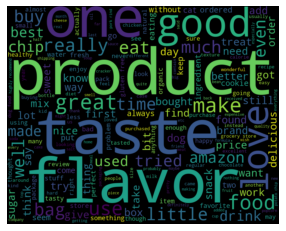

In [74]:
# Generating the word cloud for cluster1

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster1))

# Displaying the word cloud for cluster1

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

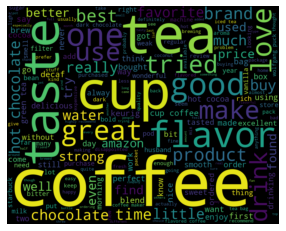

In [75]:
# Generating the word cloud for cluster2

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster2))

# Displaying the word cloud for cluster2

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

## Building Agglomerative Clustering with n_clusters=5

In [76]:
from sklearn.cluster import AgglomerativeClustering
Agg_avgw2v=AgglomerativeClustering(n_clusters=5)
Agg_avgw2v.fit(X_avgw2v_std)# Fitting the data

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5,
                        pooling_func='deprecated')

In [77]:
# Finding the clusters labels
clusters_Aggavgw2v=Agg_avgw2v.labels_

In [78]:
cluster1=[]
cluster2=[]
cluster3=[]
cluster4=[]
cluster5=[]

for i in range(len(clusters_Aggavgw2v)):
    if clusters_Aggavgw2v[i]==0:
        cluster1.append(X[i])
    elif clusters_Aggavgw2v[i]==1:
        cluster2.append(X[i])
    elif clusters_Aggavgw2v[i]==2:
        cluster3.append(X[i])
    elif clusters_Aggavgw2v[i]==3:
        cluster4.append(X[i])
        
    else:
        cluster5.append(X[i])
        

In [79]:
print("Cluster1 length:",len(cluster1))
print("Cluster2 length:",len(cluster2))
print("Cluster3 length:",len(cluster3))
print("Cluster4 length:",len(cluster4))
print("Cluster5 length:",len(cluster5))

Cluster1 length: 2277
Cluster2 length: 1096
Cluster3 length: 1997
Cluster4 length: 797
Cluster5 length: 3397


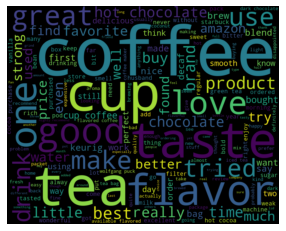

In [80]:
# Generating the word cloud for cluster1

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster1))

# Displaying the word cloud for cluster1

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

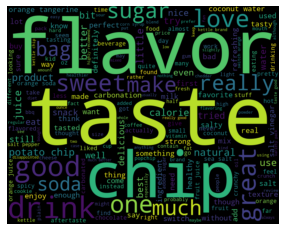

In [81]:
# Generating the word cloud for cluster2

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster2))

# Displaying the word cloud for cluster2

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

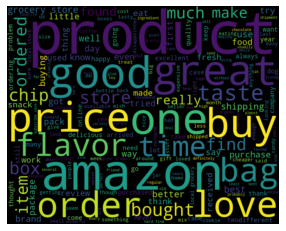

In [82]:
# Generating the word cloud for cluster3

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster3))

# Displaying the word cloud for cluster3

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

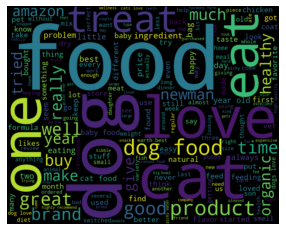

In [83]:
# Generating the word cloud for cluster4

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster4))

# Displaying the word cloud for cluster4

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

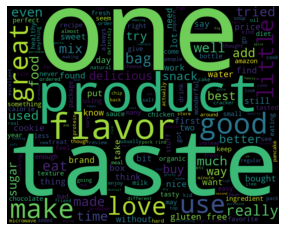

In [84]:
# Generating the word cloud for cluster5

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster5))

# Displaying the word cloud for cluster5

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

### Applying Agglomerative Clustering on TFIDF W2V

In [85]:
model = TfidfVectorizer(min_df=10,max_features=500)
tf_idf_matrix_X = model.fit_transform(X)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [86]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_X = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_X): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_X.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 9564/9564 [00:16<00:00, 589.26it/s]


In [87]:
tfidf_sent_vectors_X= np.array(tfidf_sent_vectors_X)

In [88]:
print(tfidf_sent_vectors_X.shape)
print(tfidf_sent_vectors_X[0])

(9564, 50)
[-0.75866628 -0.06827117  0.26392693 -0.49697624  0.43574581  0.32709679
  0.16947319 -0.24871064  0.99226352  0.7160166   0.02376745  0.04072772
 -0.10438786 -0.97745389  0.44196747  0.60943571 -0.26347863  0.09170349
 -0.0835232  -0.28178869  0.11593104  0.22046685 -0.68502264 -0.27765366
  0.57171974  0.07141249 -0.39242226 -0.54881751  0.30624886  0.44779929
  0.16429256  1.00473321  0.30602484 -0.76303353  0.0980529   0.89455697
  0.40768443 -0.42664077 -0.30023887 -0.14809662  0.34579096 -0.05862071
  0.54213008  0.11653376 -0.2677976   0.30789501 -0.14151085 -0.97091001
 -0.17946262  0.48074085]


## Building Agglomerative Clustering with n_clusters=2

In [89]:
# Standardizing the data

from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_tfidfavgw2v_std=sc.fit_transform(tfidf_sent_vectors_X)

In [90]:
from sklearn.cluster import AgglomerativeClustering
Agg_tfidfavgw2v=AgglomerativeClustering(n_clusters=2)
Agg_tfidfavgw2v.fit(X_tfidfavgw2v_std)# Fitting the data

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2,
                        pooling_func='deprecated')

In [91]:
# Finding the clusters labels
clusters_Aggatfidfvgw2v=Agg_tfidfavgw2v.labels_

In [92]:
np.unique(clusters_Aggatfidfvgw2v)

array([0, 1], dtype=int64)

In [93]:
len(clusters_Aggatfidfvgw2v)


9564

### Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V

In [94]:
cluster1=[]
cluster2=[]

for i in range(len(clusters_Aggatfidfvgw2v)):
    if clusters_Aggatfidfvgw2v[i]==0:
        cluster1.append(X[i])
    
    else:
        cluster2.append(X[i])
        

In [95]:
print("Cluster1 length:",len(cluster1))
print("Cluster2 length:",len(cluster2))

Cluster1 length: 7642
Cluster2 length: 1922


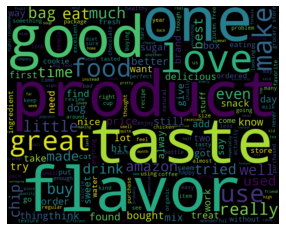

In [96]:
# Generating the word cloud for cluster1

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster1))

# Displaying the word cloud for cluster1

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

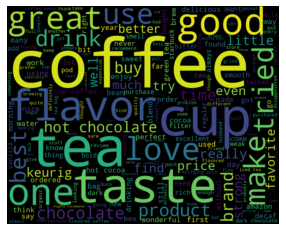

In [97]:
# Generating the word cloud for cluster2

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster2))

# Displaying the word cloud for cluster2

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

## Building Agglomerative Clustering with n_clusters=5

In [98]:
from sklearn.cluster import AgglomerativeClustering
Agg_tfidfavgw2v=AgglomerativeClustering(n_clusters=5)
Agg_tfidfavgw2v.fit(X_tfidfavgw2v_std)# Fitting the data

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5,
                        pooling_func='deprecated')

In [99]:
# Finding the clusters labels
clusters_Aggatfidfvgw2v=Agg_tfidfavgw2v.labels_

In [100]:
cluster1=[]
cluster2=[]
cluster3=[]
cluster4=[]
cluster5=[]

for i in range(len(clusters_Aggatfidfvgw2v)):
    if clusters_Aggatfidfvgw2v[i]==0:
        cluster1.append(X[i])
    elif clusters_Aggatfidfvgw2v[i]==1:
        cluster2.append(X[i])
    elif clusters_Aggatfidfvgw2v[i]==2:
        cluster3.append(X[i])
    elif clusters_Aggatfidfvgw2v[i]==3:
        cluster4.append(X[i])
        
    else:
        cluster5.append(X[i])
        

In [101]:
print("Cluster1 length:",len(cluster1))
print("Cluster2 length:",len(cluster2))
print("Cluster3 length:",len(cluster3))
print("Cluster4 length:",len(cluster4))
print("Cluster5 length:",len(cluster5))

Cluster1 length: 2645
Cluster2 length: 1922
Cluster3 length: 1884
Cluster4 length: 793
Cluster5 length: 2320


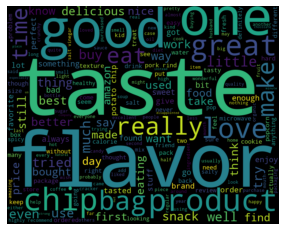

In [102]:
# Generating the word cloud for cluster1

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster1))

# Displaying the word cloud for cluster1

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

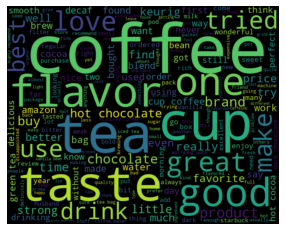

In [103]:
# Generating the word cloud for cluster2

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster2))

# Displaying the word cloud for cluster2

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

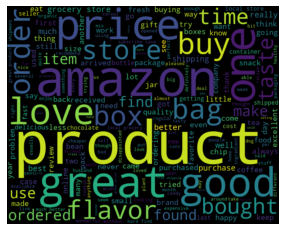

In [104]:
# Generating the word cloud for cluster3

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster3))

# Displaying the word cloud for cluster3

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

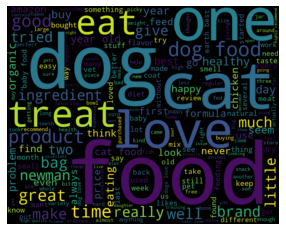

In [105]:
# Generating the word cloud for cluster4

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster4))

# Displaying the word cloud for cluster4

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

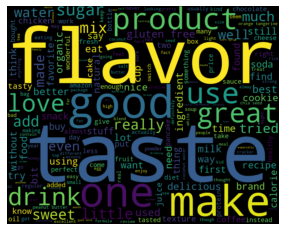

In [106]:
# Generating the word cloud for cluster5

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster5))

# Displaying the word cloud for cluster5

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

##  DBSCAN Clustering

### Applying DBSCAN on AVG W2V

In [107]:
list_of_sentance_X=[]
for sentance in X:
    list_of_sentance_X.append(sentance.split())

In [108]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [109]:
# This line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_X,min_count=5,size=50, workers=4)

In [110]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5652
sample words  ['purchased', 'product', 'local', 'store', 'ny', 'kids', 'love', 'quick', 'easy', 'meal', 'put', 'toaster', 'oven', 'toast', 'min', 'ready', 'eat', 'strongly', 'recommend', 'hi', 'disappointed', 'past', 'shipment', 'received', 'one', 'coconut', 'water', 'boxes', 'leaking', 'spoiled', 'thanks', 'finest', 'maple', 'syrups', 'ordered', 'enjoyed', 'bought', 'fancy', 'grade', 'light', 'amber', 'color', 'great', 'taste', 'reorder', 'lollipops', 'well', 'done', 'look', 'exactly']


## Converting Reviews into Numerical Vectors using W2V vectors
## Algorithm: Avg W2V

In [192]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_X): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_X = np.array(sent_vectors)


100%|█████████████████████████████████████████████████████████████████████████████| 9564/9564 [00:13<00:00, 725.41it/s]


In [193]:
print(sent_vectors_X.shape)
print(sent_vectors_X[0])

(9564, 50)
[-0.60288086 -0.05439788  0.18293035 -0.32576029  0.32692031  0.36106932
  0.12689904 -0.2432488   0.76193363  0.63603473 -0.08507906  0.12175536
 -0.06945484 -0.7885582   0.30205903  0.47690238 -0.20218697  0.08677971
 -0.10428626 -0.24674487  0.01189668  0.15554689 -0.55508463 -0.18011782
  0.33252859 -0.04910981 -0.23686558 -0.44926694  0.2008221   0.42494436
  0.00791412  0.66855026  0.25387248 -0.63938996  0.16271281  0.7124615
  0.39629863 -0.3208892  -0.21687543 -0.24082262  0.19463442 -0.03227066
  0.45640569  0.14391615 -0.26714574  0.16993912 -0.09107013 -0.80955428
 -0.20949283  0.4380772 ]


## Finding best "eps" value using elbow-knee method

In [194]:
# Standardizing the data since k-means is distance based algorithm

from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_avgw2v_std=sc.fit_transform(sent_vectors_X)

In [199]:
# Refer: https://www.youtube.com/watch?v=TGad0nc-8gU
from sklearn.neighbors import NearestNeighbors
nbrs=NearestNeighbors(n_neighbors=2).fit(X_avgw2v_std)
distances,indices=nbrs.kneighbors(X_avgw2v_std)

In [200]:
distances.shape

(9564, 2)

Text(0.5, 1.0, 'elbow-knee method to find best eps')

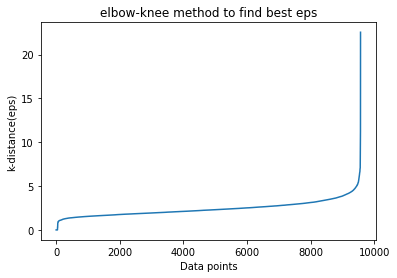

In [201]:
# Sorting the distances in ascending order

distances=np.sort(distances,axis=0)# '0' means first axis Refer:https://www.geeksforgeeks.org/numpy-sort-in-python/
distances=distances[:,1]
plt.plot(distances)
plt.xlabel("Data points")
plt.ylabel("k-distance(eps)")
plt.title("elbow-knee method to find best eps")


From the plot,we can see that the best "eps" value is 5.

## Building DBSCAN using best eps value

In [203]:
# Standardizing the data

from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_avgw2v_std=sc.fit_transform(sent_vectors_X)

In [211]:
from sklearn.cluster import DBSCAN
dbscan_avgw2v=DBSCAN(eps=5,min_samples=5,n_jobs=-1)
dbscan_avgw2v.fit(X_avgw2v_std)# Fitting the data

DBSCAN(algorithm='auto', eps=5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=-1, p=None)

In [212]:
# Finding the Clusters labels

Clusters_avgw2v_dbscan=dbscan_avgw2v.labels_

In [213]:
np.unique(Clusters_avgw2v_dbscan)

array([-1,  0,  1], dtype=int64)

In [214]:
len(Clusters_avgw2v_dbscan)

9564

### Wordclouds of clusters obtained after applying DBSCAN on AVG W2V

In [215]:
cluster1=[]
cluster2=[]
cluster3=[]

for i in range(len(Clusters_avgw2v_dbscan)):
    if Clusters_avgw2v_dbscan[i]==-1:
        cluster1.append(X[i])
    elif Clusters_avgw2v_dbscan[i]==0:
        cluster2.append(X[i])
    
    else:
        cluster3.append(X[i])
        

In [216]:
print("Cluster1 length:",len(cluster1))
print("Cluster2 length:",len(cluster2))
print("Cluster3 length:",len(cluster3))

Cluster1 length: 162
Cluster2 length: 9377
Cluster3 length: 25


In [217]:
cluster3

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

From the cluster3 ,we can see that there are no words.Therefore,wordcloud for cluster3 can not be created.

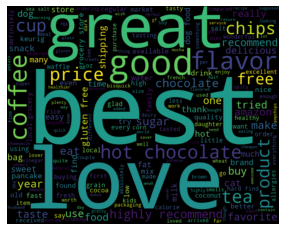

In [218]:
# Generating the word cloud for cluster1

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster1))

# Displaying the word cloud for cluster1

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

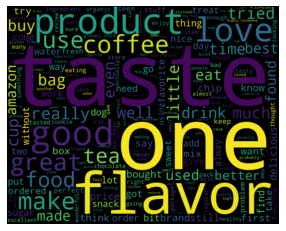

In [219]:
# Generating the word cloud for cluster2

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster2))

# Displaying the word cloud for cluster2

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

### Applying DBSCAN on TFIDF W2V

In [220]:
model = TfidfVectorizer(min_df=10,max_features=500)
tf_idf_matrix_X = model.fit_transform(X)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [221]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_X = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_X): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_X.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 9564/9564 [00:17<00:00, 559.06it/s]


In [222]:
tfidf_sent_vectors_X= np.array(tfidf_sent_vectors_X)

In [223]:
print(tfidf_sent_vectors_X.shape)
print(tfidf_sent_vectors_X[0])

(9564, 50)
[-0.81458527 -0.09561176  0.22713424 -0.41113711  0.4167318   0.43518177
  0.10580627 -0.24306795  0.90438215  0.76626671 -0.07720326  0.103342
 -0.07088258 -0.95992051  0.45427423  0.65453827 -0.24692034  0.11038568
 -0.18846556 -0.31150776  0.02306935  0.2046542  -0.65005655 -0.25214696
  0.43344023  0.01589616 -0.27693213 -0.58652489  0.31860555  0.47846361
  0.0752894   0.85043775  0.34051776 -0.86079268  0.1607111   0.86815602
  0.45566984 -0.41495119 -0.27463194 -0.3778541   0.26983477 -0.07219975
  0.5884441   0.1707135  -0.27393006  0.20553391 -0.10908363 -1.05427248
 -0.23386642  0.56895143]


## Finding best "eps" value using elbow-knee method

In [225]:
# Standardizing the data

from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_tfidfavgw2v_std=sc.fit_transform(tfidf_sent_vectors_X)

In [226]:
# Refer: https://www.youtube.com/watch?v=TGad0nc-8gU
from sklearn.neighbors import NearestNeighbors
nbrs=NearestNeighbors(n_neighbors=2).fit(X_tfidfavgw2v_std)
distances,indices=nbrs.kneighbors(X_tfidfavgw2v_std)

Text(0.5, 1.0, 'elbow-knee method to find best eps')

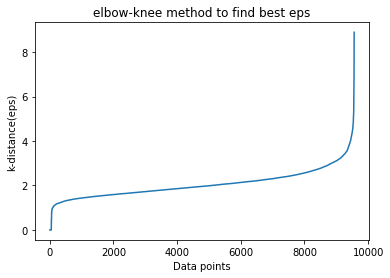

In [227]:
# Sorting the distances in ascending order

distances=np.sort(distances,axis=0)# '0' means first axis Refer:https://www.geeksforgeeks.org/numpy-sort-in-python/
distances=distances[:,1]
plt.plot(distances)
plt.xlabel("Data points")
plt.ylabel("k-distance(eps)")
plt.title("elbow-knee method to find best eps")


From the plot,we can see that the best eps value is 3.

## Building DBSCAN with best eps value

In [228]:
# Standardizing the data

from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_avgw2v_std=sc.fit_transform(sent_vectors_X)

In [230]:
from sklearn.cluster import DBSCAN
dbscan_tfidfavgw2v=DBSCAN(eps=3,min_samples=5,n_jobs=-1)
dbscan_tfidfavgw2v.fit(X_avgw2v_std)# Fitting the data

DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=-1, p=None)

In [231]:
# Finding the Clusters labels

Clusters_tfidfavgw2v_dbscan=dbscan_tfidfavgw2v.labels_

In [232]:
np.unique(Clusters_tfidfavgw2v_dbscan)

array([-1,  0,  1,  2,  3,  4,  5], dtype=int64)

### Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V

In [233]:
cluster1=[]
cluster2=[]
cluster3=[]
cluster4=[]
cluster5=[]
cluster6=[]
cluster7=[]

for i in range(len(Clusters_tfidfavgw2v_dbscan)):
    if Clusters_tfidfavgw2v_dbscan[i]==-1:
        cluster1.append(X[i])
    elif Clusters_tfidfavgw2v_dbscan[i]==0:
        cluster2.append(X[i])
    elif Clusters_tfidfavgw2v_dbscan[i]==1:
        cluster3.append(X[i])
    elif Clusters_tfidfavgw2v_dbscan[i]==2:
        cluster4.append(X[i])
    elif Clusters_tfidfavgw2v_dbscan[i]==3:
        cluster5.append(X[i])
    elif Clusters_tfidfavgw2v_dbscan[i]==4:
        cluster6.append(X[i])
    
    else:
        cluster7.append(X[i])
        

In [234]:
print("Cluster1 length:",len(cluster1))
print("Cluster2 length:",len(cluster2))
print("Cluster3 length:",len(cluster3))
print("Cluster4 length:",len(cluster4))
print("Cluster5 length:",len(cluster5))
print("Cluster6 length:",len(cluster6))
print("Cluster7 length:",len(cluster7))

Cluster1 length: 2365
Cluster2 length: 7156
Cluster3 length: 25
Cluster4 length: 5
Cluster5 length: 5
Cluster6 length: 4
Cluster7 length: 4


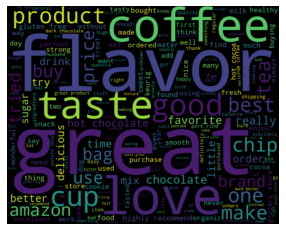

In [235]:
# Generating the word cloud for cluster1

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster1))

# Displaying the word cloud for cluster1

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

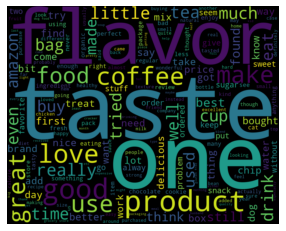

In [236]:
# Generating the word cloud for cluster2

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster2))

# Displaying the word cloud for cluster2

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [245]:
cluster3

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

From the cluster3 ,we can see that there are no words.Therefore,wordcloud for cluster3 can not be created.

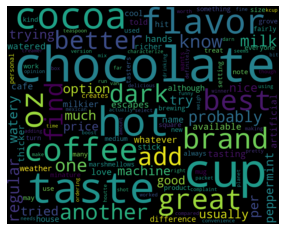

In [239]:
# Generating the word cloud for cluster4

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster4))

# Displaying the word cloud for cluster4

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

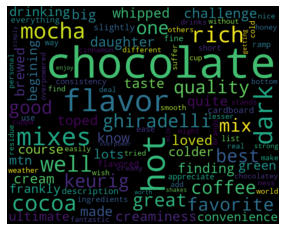

In [240]:
# Generating the word cloud for cluster5

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster5))

# Displaying the word cloud for cluster5

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

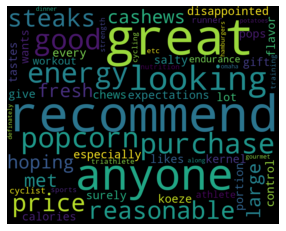

In [241]:
# Generating the word cloud for cluster6

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluaster6))

# Displaying the word cloud for cluster6

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

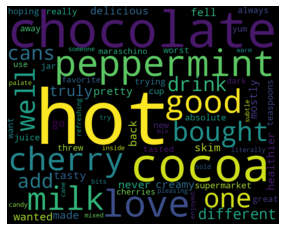

In [242]:
# Generating the word cloud for cluster7

from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(cluster7))

# Displaying the word cloud for cluster7

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

#  Conclusions

## Conculsions for k-means clustering


In [255]:
from prettytable import PrettyTable

In [256]:
x=PrettyTable()

In [257]:
x.field_names=['Vectorizer','k(number of clusters)']

In [258]:
x.add_row(['BOW',6])
x.add_row(['TFIDF',4])
x.add_row(['AvgW2V',4])
x.add_row(['TFIDF_AVGW2V',4])

In [259]:
print(x)

+--------------+-----------------------+
|  Vectorizer  | k(number of clusters) |
+--------------+-----------------------+
|     BOW      |           6           |
|    TFIDF     |           4           |
|    AvgW2V    |           4           |
| TFIDF_AVGW2V |           4           |
+--------------+-----------------------+


## Conculsions for Agglomerative clustering

In [273]:
x=PrettyTable()

In [274]:
x.field_names=['Vectorizer','number of clusters']

In [275]:
x.add_row(['AvgW2V',2])
x.add_row(['AvgW2V',5])
x.add_row(['TFIDF_AVGW2V',2])
x.add_row(['TFIDF_AVGW2V',5])

In [276]:
print(x)

+--------------+--------------------+
|  Vectorizer  | number of clusters |
+--------------+--------------------+
|    AvgW2V    |         2          |
|    AvgW2V    |         5          |
| TFIDF_AVGW2V |         2          |
| TFIDF_AVGW2V |         5          |
+--------------+--------------------+


## Conculsions for DBSCAN clustering

In [277]:
x=PrettyTable()

In [278]:
x.field_names=['Vectorizer','eps','number of clusters']

In [279]:
x.add_row(['AvgW2V',5,3])
x.add_row(['TFIDF_AVGW2V',3,7])

In [280]:
print(x)

+--------------+-----+--------------------+
|  Vectorizer  | eps | number of clusters |
+--------------+-----+--------------------+
|    AvgW2V    |  5  |         3          |
| TFIDF_AVGW2V |  3  |         7          |
+--------------+-----+--------------------+
